In [118]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import classification_report

In [119]:
data = pd.read_csv(r'income_unbalanced.csv')
data

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,244602,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,58,State-gov,110199,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
3,25,State-gov,149248,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0
4,59,State-gov,105363,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39745,52,Private,68982,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,1
39746,19,Private,116562,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,40,United-States,0
39747,30,Private,197947,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,58,United-States,0
39748,46,Private,97883,Bachelors,13,Never-married,Sales,Not-in-family,White,Female,0,0,35,United-States,0


    Начнём традиционно с анализа, что вообще есть у нас в данных. С числовыми признаками всё понятно, однако в данных много категориальных признаков. Посмотрим, какие значения они принимают и как распределены по датасету.

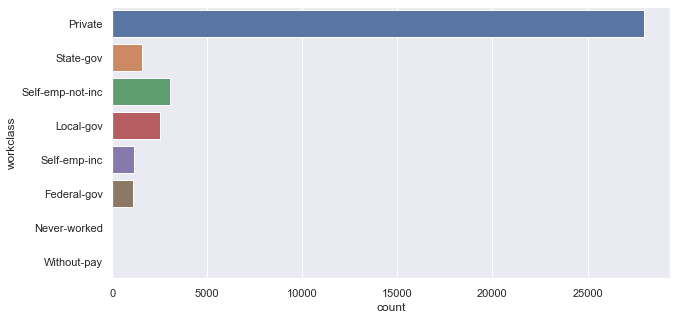

In [120]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(10,5))
sns.countplot(data=data, y = data['workclass'])

    Видим, что в данных практически нет никогда не работавших и работающих без оплаты людей. По смыслу признака очевидно, что у таких людей вряд ли может быть годовая прибыль больше 50к. Предположим, что модель будет всегда выдавать ответ 0 при этих значениях в данном столбце, и уберём их.
    
    В виду того, что практически все опрошенные для датасета люди имеют workclass Private, можем объединить некоторые другие классы по смыслу.

In [121]:
without_income = ['Never-worked', 'Without-pay']
data = data[data['workclass'].isin(without_income) == False]

work_classes = {
    'government': ['State-gov', 'Local-gov', 'Federal-gov'],
    'self_employed': ['Self-emp-inc', 'Self-emp-not-inc']
}

for name, values in work_classes.items():
    data = data.replace(values, name)

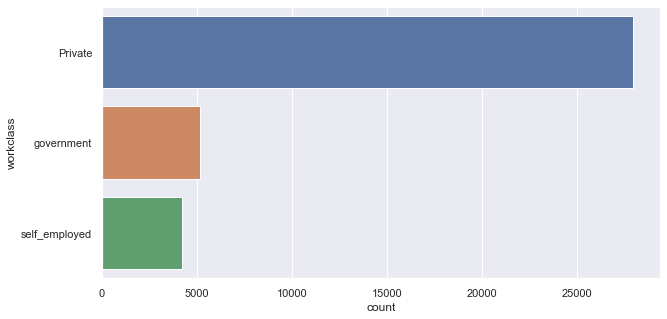

In [122]:
plt.figure(figsize=(10,5))
sns.countplot(data=data, y = data['workclass'])

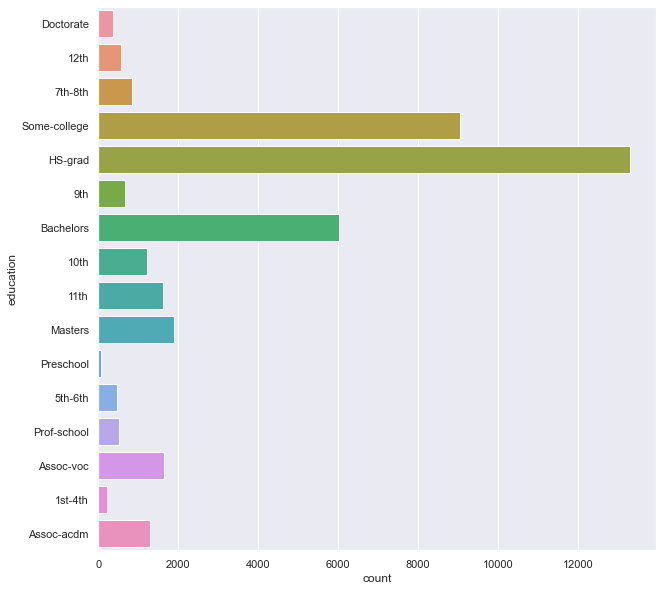

In [123]:
plt.figure(figsize=(10,10))
sns.countplot(data=data, y = data['education'])

    Так как позже станет видно, что большая часть людей, опрошенных для датасета, попробуем посмотреть официальные данные о ступенях образования в штатах. Объединим некоторые немноголюдные категории по смыслу, чтобы уменьшить количество возможных значений и иметь возможность удобнее потом их закодировать.

In [124]:
dergees = {
    'basic_school': ['Preschool', '1st-4th', '5th-6th', '7th-8th'],
    'high_school': ['9th', '10th', '11th', '12th'],
    'associate': ['Assoc-acdm', 'Assoc-voc'],
    'university_degree': ['Doctorate','Bachelors','Some-college','Masters','Prof-school']
}

for name, values in dergees.items():
    data = data.replace(values, name)

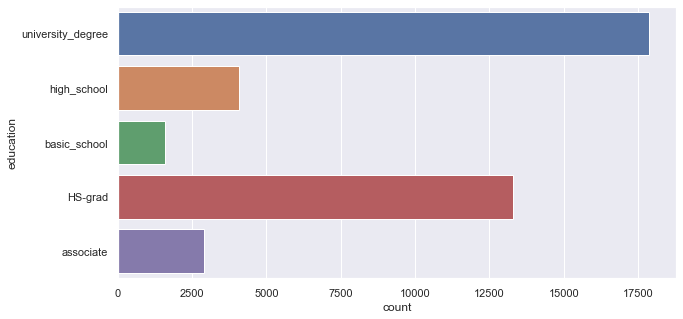

In [125]:
plt.figure(figsize=(10,5))
sns.countplot(data=data, y = data['education'])

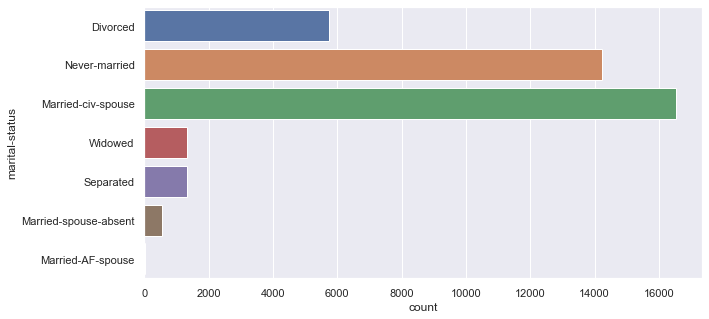

In [126]:
plt.figure(figsize=(10,5))
sns.countplot(data=data, y = data['marital-status'])

    Что касается семейного положения, то исходя из смысла признака, нас будет в общем-то интересовать только состоит человек в браке или нет. Т.к. категориальный признак будет всего 2 значения в таком случае, можем закодировать их путём прямой нумерации 1 - не в браке, 0 - в браке.

In [127]:
status = {
    'single': ['Divorced', 'Never-married', 'Widowed', 'Separated'],
    'married': ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']
}

for name, values in status.items():
    data = data.replace(values, name)

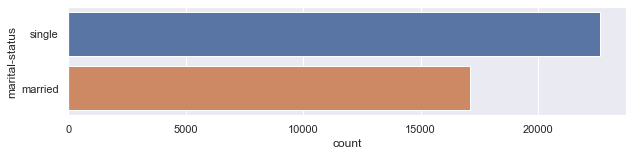

In [128]:
plt.figure(figsize=(10,2))
sns.countplot(data=data, y = data['marital-status'])

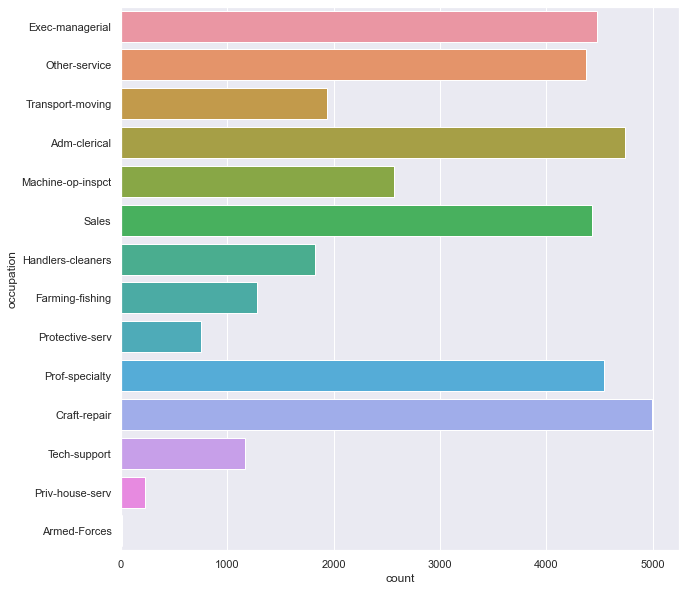

In [129]:
plt.figure(figsize=(10,10))
sns.countplot(data=data, y = data['occupation'])

    Признак occupation обозначает сферу деятельности, в которой работает человек. Сложно как-то группировать или выделить ключевую информацию, которую он может нести. Данные довольно неплохо распределены по различным значениям здесь, так что нет особого смысла как-то менять этот признак.

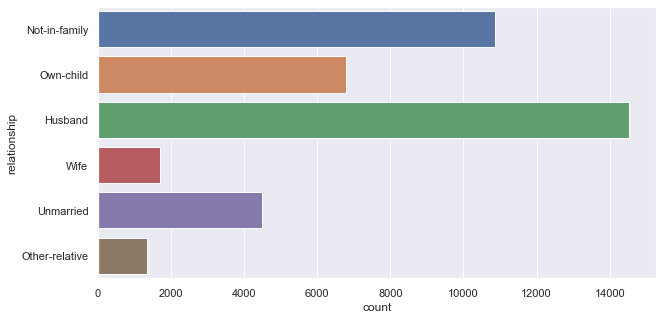

In [130]:
plt.figure(figsize=(10,5))
sns.countplot(data=data, y = data['relationship'])

    Признак relationship частично повторяет информацию о гражданском состоянии человека, которая у нас уже есть в предыдущем признаке. Кроме этого здесь также повторяется информация о половой принадлежности, т.к. есть муж/жена. Не очень понятно, какой смысл несёт значение own-child. Если это семьи с детьми, то этот признак мог бы быть полезным, но если посмотреть распределение итоговых значений income_>50k, то получается странная статистика, что практически все они имеют малый доход:

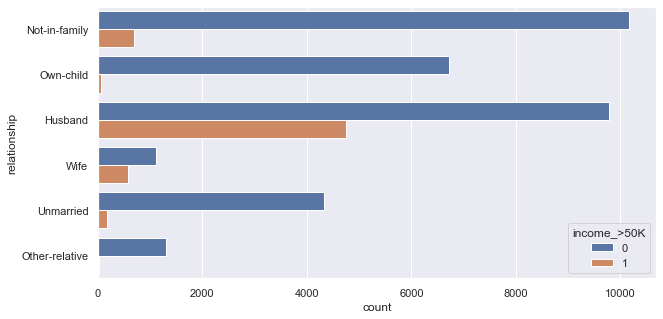

In [131]:
plt.figure(figsize=(10,5))
sns.countplot(data=data, y='relationship', hue='income_>50K')

    Т.к. анализ смысла данного признака не подсказывает ничего умного, оставим его, как есть.

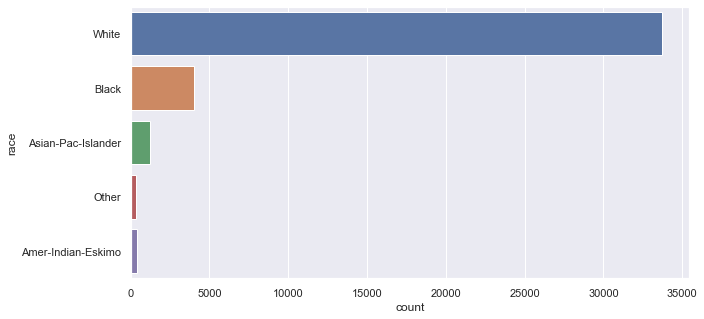

In [132]:
plt.figure(figsize=(10,5))
sns.countplot(data=data, y = data['race'])

    Т.к. большинство людей в опросе white, возьмём из этого признака только информацию о том, White наш человек или нет.

In [133]:
race = {
    'other': ['Black', 'Asian-Pac-Islander', 'Other', 'Amer-Indian-Eskimo']
}

for name, values in race.items():
    data = data.replace(values, name)

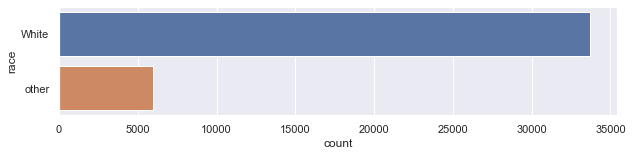

In [134]:
plt.figure(figsize=(10,2))
sns.countplot(data=data, y = data['race'])

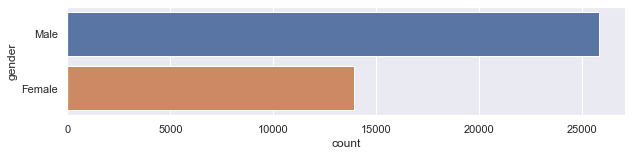

In [135]:
plt.figure(figsize=(10,2))
sns.countplot(data=data, y = data['gender'])

    Как поступим с полом, уже понятно:)

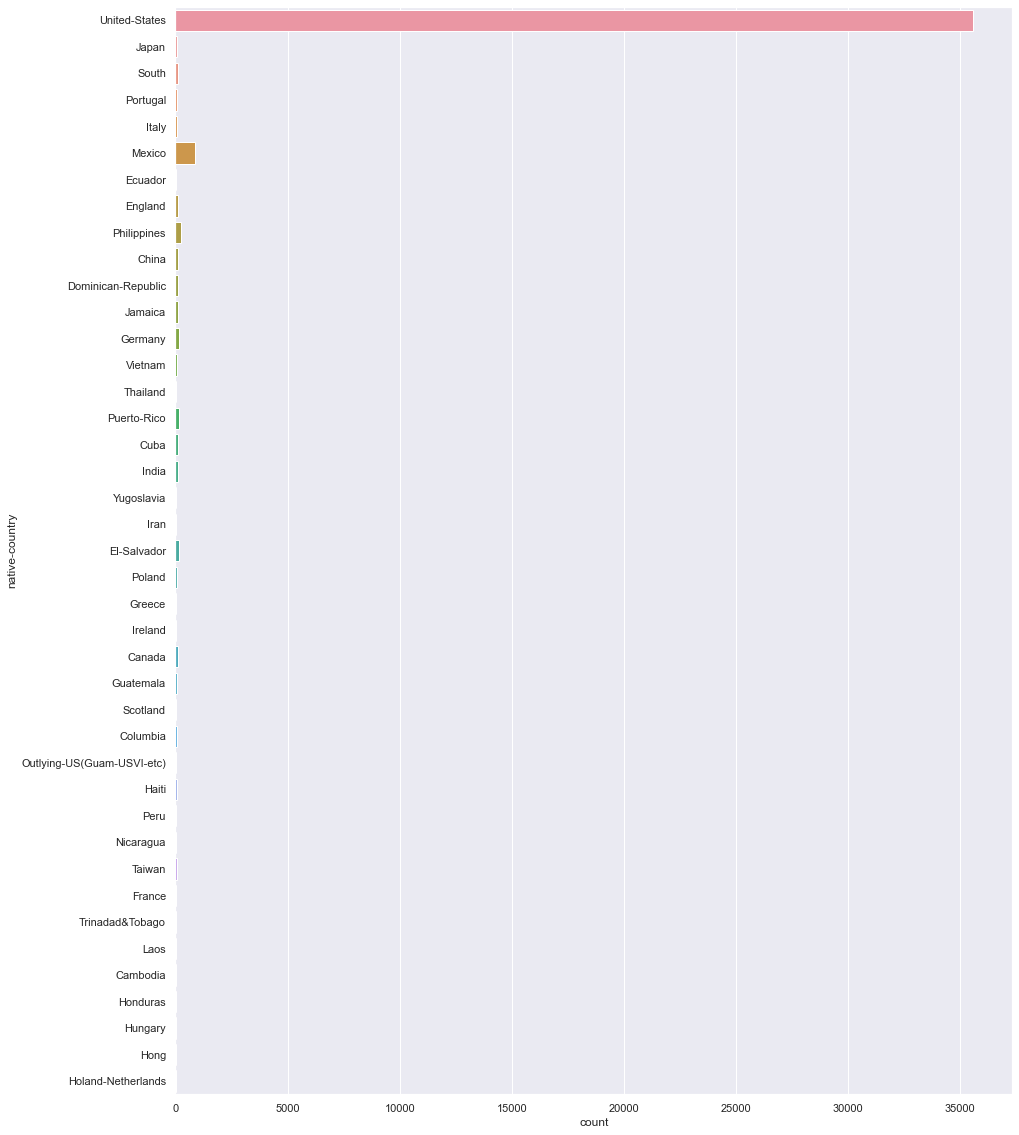

In [136]:
plt.figure(figsize=(15,20))
sns.countplot(data=data, y = data['native-country'])

    И вот наконец мы пришли к признаку родной страны. У нас почти все опрошенные граждане родом из USA, в целом не имеет особого смысла ориентироваться на этот признак, т.к. по сравнению с уроженцами USA другие страны очень мало представлены.

    Теперь наконец закодируем признаки.

In [137]:
data['gender'] = pd.get_dummies(data['gender'], drop_first=True)
data['marital-status'] = pd.get_dummies(data['marital-status'], drop_first=True)
data['race'] = pd.get_dummies(data['race'], drop_first=True)

    Чтобы не плодить много столбцов с большим числом нулей путём one-hot кодирования всех категориальных признаков, было решено найти какой-нибудь вариант поинтеллектуальнее, но не очень сложный. Поэтому был выбран target-encoder, если я правильно поняла смысл, он заменяет категорию (например, категория Private признака workclass) вероятностью появления 1 в целевом признаке (income_>50K в нашем случае) при условии, что кодируемый признак принимает данную категорию (т.е. P {income_>50K = 1 | workclass = Private}).
    
    (One-hot я тоже попробовала, но получилось достаточно ужасно, решила не оставлять даже для примера.)

In [138]:
import category_encoders as ce

category_columns = ['workclass', 'education', 'occupation', 'relationship', 'native-country']
encoder = ce.TargetEncoder(
    cols=category_columns
)
    
data[category_columns] = encoder.fit_transform(data[category_columns], data['income_>50K']).astype('float32')
data

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,67,0.142980,366425,0.240336,16,1,0.358356,0.063881,0,1,99999,0,60,0.163044,1
1,17,0.142980,244602,0.034984,8,1,0.025143,0.009869,0,1,0,0,15,0.163044,0
2,58,0.217611,110199,0.031546,4,0,0.123259,0.327325,0,1,0,0,40,0.163044,0
3,25,0.217611,149248,0.240336,10,1,0.025143,0.063881,1,1,0,0,40,0.163044,0
4,59,0.217611,105363,0.100211,9,1,0.086443,0.009869,0,1,0,0,40,0.163044,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39745,52,0.142980,68982,0.240336,13,0,0.358356,0.327325,0,1,0,0,50,0.163044,1
39746,19,0.142980,116562,0.100211,9,1,0.025143,0.009869,0,0,0,0,40,0.163044,0
39747,30,0.142980,197947,0.240336,10,1,0.180894,0.063881,0,1,0,0,58,0.163044,0
39748,46,0.142980,97883,0.240336,13,1,0.180894,0.063881,0,0,0,0,35,0.163044,0


    И наконец посмотрим, какие данные у нас получились.

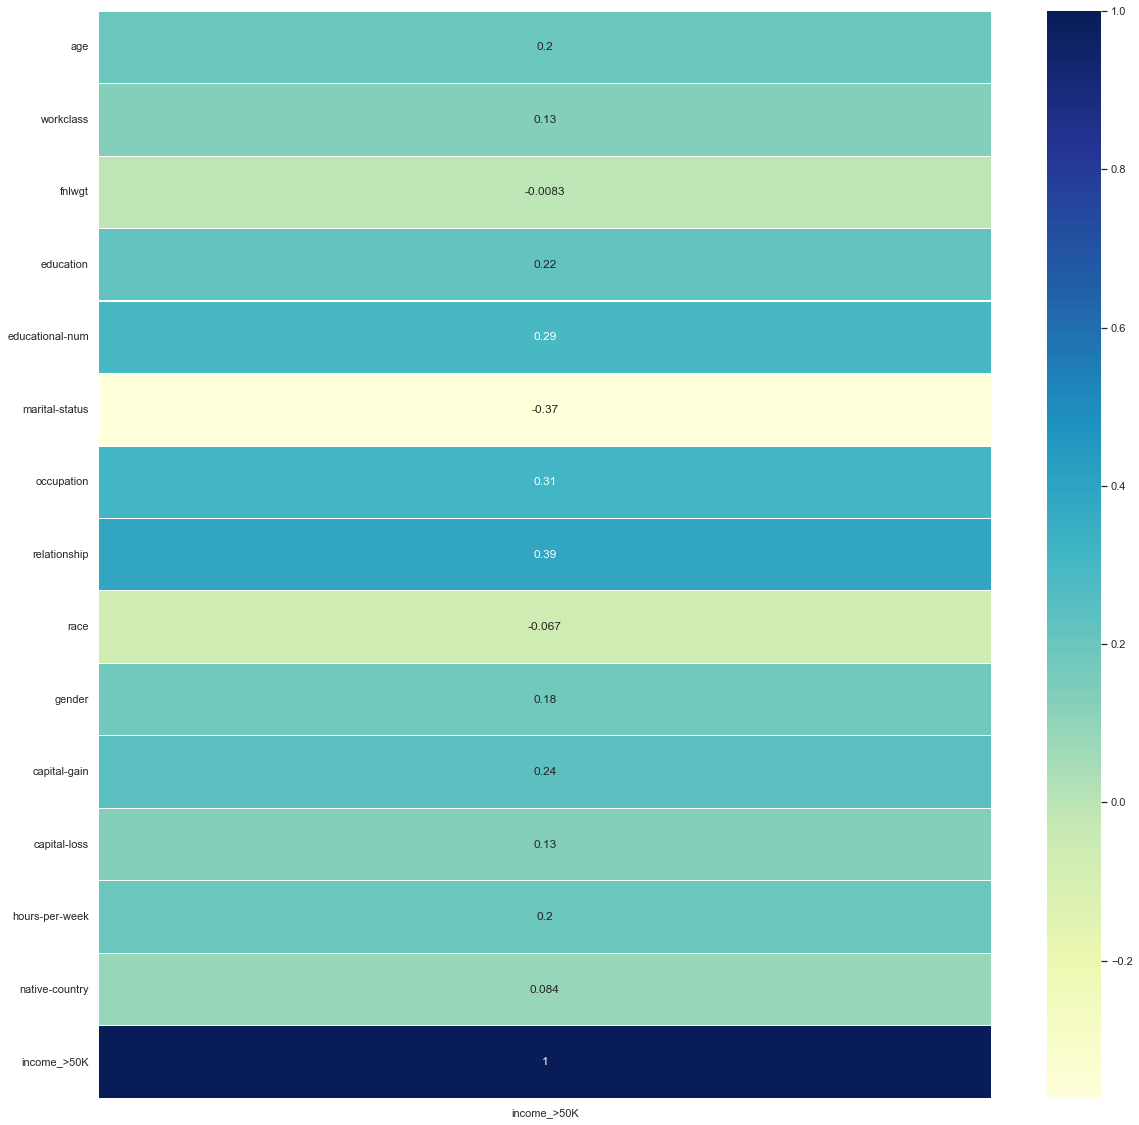

In [139]:
corrmat = data.corr()
corrmat = pd.DataFrame(corrmat['income_>50K'])

plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, cmap ="YlGnBu", linewidths = 0.1, annot=True,)

    Некоторые данные не несут практически никакой полезной информации, что видно выше по тому, что корреляция с искомым признаком у них ничтожно маленькая и находится возле нуля. При этом в таких алгоритмах, как случайный лес, очевидно, что наличие таких признаков будет только мешать, т.к. мы будем вынуждать классификатор принимать решения по таким признакам в том числе. По сему было принято волевое решение дропнуть их, что положительно сказалось на полученных результатах.

In [140]:
data = data.drop(['fnlwgt', 'race', 'native-country'], axis=1)

    Сравнения ради были взяты следующие классификаторы: дерево, случайный лес, логистическая регрессия и классификатор на основе градиентного бустинга. Для честности данные были разделены на 5 фолдов для кросс-валидации.

In [141]:
k = 5

X, y = data.drop(columns='income_>50K'), data['income_>50K']
kfold = KFold(k, shuffle=True, random_state=42)

for i, (train, test) in enumerate(kfold.split(data)):
    X_train, y_train = X.iloc[train], y.iloc[train]
    X_test, y_test = X.iloc[test], y.iloc[test]

    forest = RandomForestClassifier(
        n_estimators=100,
        max_features = 4,
        max_depth=5,
        n_jobs=4,
        bootstrap=True
    )
    
    tree = DecisionTreeClassifier(
        max_depth=5
    )
    
    tree.fit(X_train, y_train)
    forest.fit(X_train, y_train)

    y_predicted_forest = forest.predict(X_test)
    y_predicted_tree = tree.predict(X_test) 
    
    print(f'\n================= Fold {i+1} =====================')
    
    print('\t'*3,'Tree', u"\U0001F333")
    print(classification_report(y_test, y_predicted_tree))
    print('ROC-AUC score', roc_auc_score(y_test, y_predicted_tree), '\n')
    
    print('\t'*2,'Forest', u"\U0001F333"*6)
    print(classification_report(y_test, y_predicted_forest))
    print('ROC-AUC score', roc_auc_score(y_test, y_predicted_forest), '\n')
    
    logreg = LogisticRegression(
        penalty='l2',
        max_iter=1000
    )
    
    scaler = MinMaxScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)
    
    logreg.fit(X_train_norm, y_train)
    y_predicted_logreg = logreg.predict(X_test_norm)
    
    print('\t'*2,'Logistic regression',)
    print(classification_report(y_test, y_predicted_logreg))
    print('ROC-AUC score', roc_auc_score(y_test, y_predicted_logreg), '\n')
    
    boosting = GradientBoostingClassifier(
        max_depth=1,
        min_samples_leaf=5,
        learning_rate=0.5,
        n_estimators=100
    )

    boosting.fit(X_train, y_train)
    y_predicted_boosting = boosting.predict(X_test)
    
    print('\t'*2,'Gradient boosting',)
    print(classification_report(y_test, y_predicted_boosting))
    print('ROC-AUC score', roc_auc_score(y_test, y_predicted_boosting), '\n')


================= Fold 1 =====================
			 Tree 🌳
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      6647
           1       0.73      0.51      0.60      1298

    accuracy                           0.89      7945
   macro avg       0.82      0.74      0.77      7945
weighted avg       0.88      0.89      0.88      7945

ROC-AUC score 0.7378091834702819 

		 Forest 🌳🌳🌳🌳🌳🌳
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      6647
           1       0.78      0.47      0.58      1298

    accuracy                           0.89      7945
   macro avg       0.84      0.72      0.76      7945
weighted avg       0.88      0.89      0.88      7945

ROC-AUC score 0.720967416281729 

		 Logistic regression
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      6647
           1       0.73      0.45      0.55      1298

    accuracy  

    Вот такой вот интересный на этих данных имеем результат. Кроме этого также был проведён эксперимент по восстановлению nan значений, но это не повлияло в положительную сторону на результаты.